In [28]:
import os, sys, random, numpy as np, scipy as sp
import phate, scprep, graphtools
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

## Add local development version of PHATE to python path

In [ ]:
sys.path.append(os.path.abspath('../phate'))
# sys.path = sys.path[:-2]

## Create test data

In [19]:
tree, branches = phate.tree.gen_dla(
    n_dim = 200, n_branch = 10, branch_length = 300, rand_multiplier = 2, seed=37, sigma = 5
)
data = tree
clusters = branches

In [20]:
phate_op = phate.PHATE()
data_ph = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 3000 observations and 200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.80 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.40 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 1.22 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.03 seconds.
  Calculated landmark operator in 2.55 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 2.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.50 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.82 seconds.
Calculated PHATE in 8.84 seconds.


## Load Predictor

In [14]:
from branch_prediction import BranchPointPredictor

## Fit predictor

In [21]:
bpp = BranchPointPredictor(phate_op)

/opt/homebrew/Caskroom/miniforge/base/envs/mps/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/opt/homebrew/Caskroom/miniforge/base/envs/mps/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


BranchPointPredictor(phate_op=PHATE())

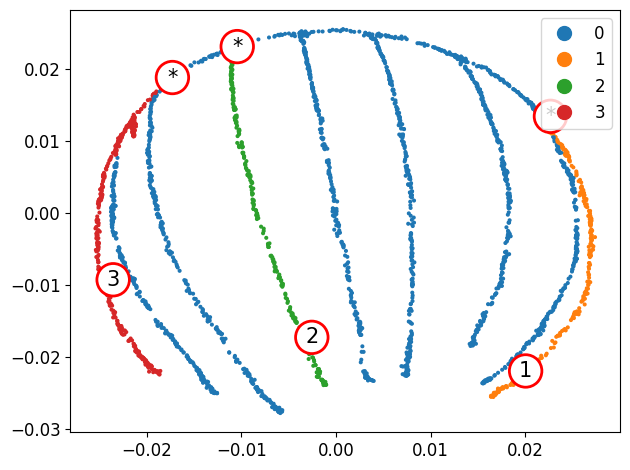

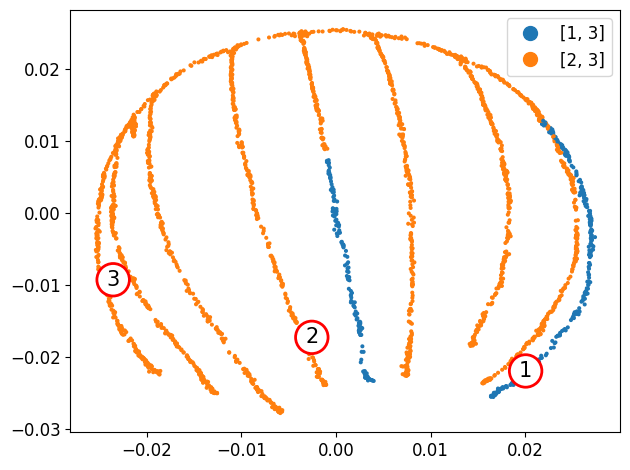

In [22]:
bpp.fit(data_ph)

In [26]:
bpp.branch_points, np.unique(bpp.branch_classes)

(array([  6, 603, 247]), array(['[1, 3]', '[2, 3]'], dtype='<U6'))

## Compare to code in `./branch_prediction.py`

In [32]:
################
# DISTINCTNESS #
################
# Find and sort eigenvectors and eigenvalues of diffusion operators. 
phate_op_eigvals, phate_op_eigvecs = np.linalg.eig(phate_op.diff_op)
idx = np.abs(phate_op_eigvals).argsort()[::-1]
phate_op_eigvals = phate_op_eigvals[idx]
phate_op_eigvecs = phate_op_eigvecs[:,idx]
phate_op_eigvals = np.power(phate_op_eigvals, phate_op.optimal_t)
phate_op_eigvecs = phate_op_eigvecs.dot(np.diag(phate_op_eigvals))


In [33]:
# Number of eigenvectors (~ dimensions) to consider.
phate_op_eigvals_diff = phate_op_eigvals - np.roll(phate_op_eigvals, 1)
n_eigvecs = 1

In [34]:
# Increase the number of eigenvectors until 
while (phate_op_eigvals_diff[n_eigvecs + 1]
  > 2 * phate_op_eigvals_diff[n_eigvecs]):
  n_eigvecs += 1
n_eigvecs

4

In [35]:
# NOTE: this matches bpp.n_use
bpp.n_use

4

In [36]:
# Find the extremas (min and max) of the considered eigenvectors.
# Keep them in the order of the eigenvalues by weaving min and max values.
# min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
# max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
# combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
# combined_eigs[0::2] = min_eigs
# combined_eigs[1::2] = max_eigs

# Remove duplicates.

# for e in combined_eigs:
#     if e not in most_distinct_points:
#         most_distinct_points.append(e)

most_distinct_points = []

# Always skip the first trivial eigenvector
for i in np.arange(n_eigvecs):
  cur_eigvec = np.copy(phate_op_eigvecs[:,i + 1])
  # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative values and vice versa). This part ensures only the extrema on the more significant side is taken.
  lower_half_abs = np.percentile(np.abs(cur_eigvec), 50)
  cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0
  max_eig = np.argmax(cur_eigvec)
  min_eig = np.argmin(cur_eigvec)
  if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
    most_distinct_points.append(max_eig)
  if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
    most_distinct_points.append(min_eig)

most_distinct_points = np.array(most_distinct_points)

In [46]:
# These extremas could contain branch points but 
# We will classify them based on their intrinsic dimensionality.

#######################
# INTRINSIC DIMENSION #
#######################

# Based on maxLikPointwiseDimEst() of this R package.
# https://cran.r-project.org/web/packages/intrinsicDimension/README.html

# Up to 100 dimensions of diffusion maps, 
# raised to the same power as tdetermined by PHATE.
dm_dims = min(data.shape[1], 100)
diff_map = phate_op_eigvecs[:,:dm_dims]

**NOTE** change from current code in `./branch_prediction.py` as that implementation doesn't handle landmark operators

In [47]:
diff_map.shape, (bpp.pmn @ diff_map).shape

((1840, 100), (3000, 100))

In [48]:
diff_map = (bpp.pmn @ diff_map)

In [54]:

# diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))

# Rank all neighbors in diffusion map coordinates.
nbrs = NearestNeighbors(
  # n_neighbors=dm_dims,
  n_neighbors=diff_map.shape[0],
  algorithm='ball_tree'
  ).fit(diff_map)
nn_distances, nn_indices = nbrs.kneighbors(diff_map)
nn_distances = nn_distances[:,1:]
nn_indices = nn_indices[:,1:]

# Maximum Likelihood pointwise dimensionality estimation
# Hill (1975), Levina and Bickel (2005)
row_max = np.max(nn_distances, axis=1)
row_max = row_max.reshape(len(row_max), 1)
dim_est = np.sum(np.log(row_max / nn_distances), axis=1)

# Calculate the average dim_est of local neighborhood.
n_nbrs = min(data.shape[0] // 20, 100)
nbrs_dim_est = np.average(dim_est[nn_indices[:,:n_nbrs]], axis=1)

# Calculate ranking of neighborhood dim_est, from low to high
temp = nbrs_dim_est.argsort()
nbrs_dim_est_ranks = np.empty_like(temp)
nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

# Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
most_distinct_points = most_distinct_points[low_dim_est_mask]


In [57]:
# NOTE: copy-pasted my code from `phate.branch_prediction.py`
#       to handle landmarked graph
is_landmarked = True

##################################
# DIFFUSING DIRAC FOR END POINTS #
##################################

branch_points = []
classes = np.zeros(data.shape[0], dtype="int32")
classes_value = np.repeat(-float('inf'), data.shape[0])
for end_point_index in np.arange(most_distinct_points.size):
  cur_end_point = most_distinct_points[end_point_index]


  # NOTE: begin change
  if is_landmarked:
      undo_diff = (bpp.pmn @ phate_op.diff_op @ bpp.pnm)
      diff_op_t = np.linalg.matrix_power(undo_diff, phate_op.optimal_t)
  else:
      diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)            
  # NOTE: end change
  # NOTE: original
  # diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)
  
  
  branch_point_dim_est_avg_cache = -float('inf')
  for it in range(20):
    branch_from_end_point = diff_op_t[:,cur_end_point]
    branch_max = np.max(branch_from_end_point)
    branch_min = np.min(branch_from_end_point)
    branch_threshold = branch_min + (branch_max - branch_min) * 0.2
    deviation_from_branch_threshold = \
      branch_from_end_point - branch_threshold
    deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = \
      float('inf')
    cur_branch_point = deviation_from_branch_threshold.argmin()
    potential_branch_points = \
      np.argpartition(deviation_from_branch_threshold, 20)[:20]
    branch_point_dim_est_avg = \
      np.average(nbrs_dim_est[potential_branch_points])
    if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
      break
    branch_point_dim_est_avg_cache = branch_point_dim_est_avg

    # NOTE: begin change
    if is_landmarked:                                
        undo_diff = (bpp.pmn @ phate_op.diff_op @ bpp.pnm)
        diff_op_t = diff_op_t.dot(undo_diff)
    else:
        diff_op_t = diff_op_t.dot(phate_op.diff_op)
    # NOTE: end change

    # NOTE: original
    # diff_op_t = diff_op_t.dot(phate_op.diff_op)
  
  branch_points.append(cur_branch_point)
  on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
  color = diff_op_t[:,cur_end_point]
  on_branch_mask[color < classes_value] = 0
  color[np.logical_not(on_branch_mask)] = -np.max(color)
  classes_value[on_branch_mask] = color[on_branch_mask]
  classes[on_branch_mask] = end_point_index + 1
  # ax = scprep.plot.scatter2d(data_ph, c=color)
  # plot_numbers = np.repeat("", data_ph.shape[0])
  # plot_numbers[cur_end_point] = 'e'
  # plot_numbers[cur_branch_point] = 'b'
  # bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
  # sys.stdout = open('trash', 'w')
  # for i, txt in enumerate(plot_numbers):
  #   ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)
  # sys.stdout = sys.__stdout__

In [58]:
#####################
# REMOVE DUPLICATES #
#####################
# We want to remove branch points that are too close together.

branch_points = np.array(branch_points)
branch_point_nbrs = nn_indices[branch_points,:n_nbrs]
branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

# For each pair of branch_points, keep only the one with higher eigenvalue.
# (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
# to the first point of each pair.)
points_to_exclude = []
for pair in branch_point_pairs:
  if pair[0] not in points_to_exclude:
    points_to_exclude.append(pair[1])

branch_points = np.delete(branch_points,
  np.argwhere(np.isin(branch_points, points_to_exclude)))

/opt/homebrew/Caskroom/miniforge/base/envs/mps/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


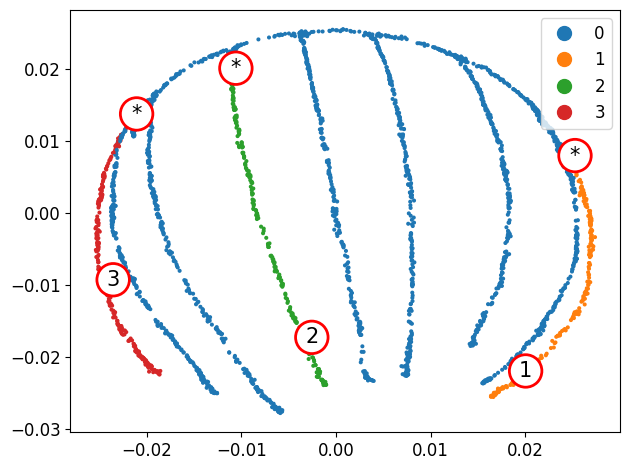

In [59]:
####################
# PLOTTING RESULTS #
####################

# Plot by class with end points and branch points
ax = scprep.plot.scatter2d(data_ph, c=classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
plot_numbers[branch_points] = "*"
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

# sys.stdout = sys.__stdout__

/opt/homebrew/Caskroom/miniforge/base/envs/mps/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


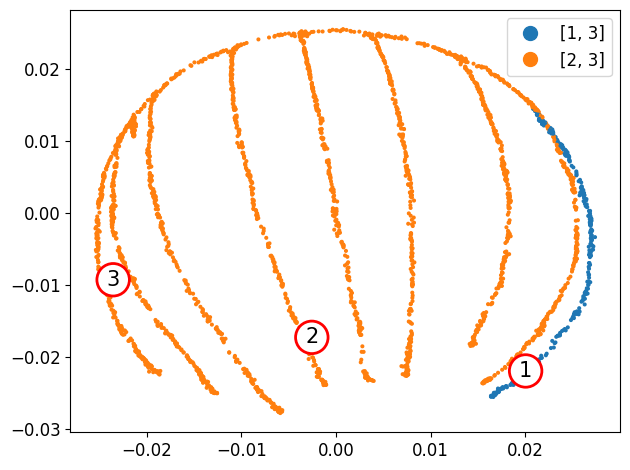

In [61]:
###################
# ASSIGN BRANCHES #
###################

# Find coordinates between every point and every MDP.
all_dm_coords = diff_map
mdp_dm_coords = diff_map[most_distinct_points,:]
pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

# For every point, rank MDPs by increasing distance.
s = np.argsort(pairwise_dist, axis=1)
i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
j = np.arange(pairwise_dist.shape[1])
mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
mdp_ranking[i, s] = j + 1

# Assign every point to the branch between its two most highly ranked MDPs.
mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
branch_classes = list(zip(mdp_1, mdp_2))
branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
ax = scprep.plot.scatter2d(data_ph, c=branch_classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

# sys.stdout = sys.__stdout__
